In [1]:
from models import SequenceDNN_Regression

from collections import OrderedDict
from pprint import pprint
from warnings import warn

import numpy as np
import matplotlib.pyplot as plt

import math

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
data_dir = 'data/'
model_dir = 'models/'

acceptable_keys = {}
    
key_to_seq = {}
seq_len = 145

with open("../../data/Scaleup_counts_sequences/ScaleUpDesign1.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        cats = key.split('_')
        bucket = "".join([cats[0], cats[4], cats[5]])

        if "N" in seq:
            seq = seq.replace("N", "A")

        if bucket not in key_to_seq:
            key_to_seq[bucket] = [(seq, key)]
        else:
            key_to_seq[bucket].append((seq, key))

with open("../../data/Scaleup_counts_sequences/ScaleUpDesign2.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        cats = key.split('_')
        bucket = "".join([cats[0], cats[4], cats[5]])

        if "N" in seq:
            seq = seq.replace("N", "A")

        if bucket not in key_to_seq:
            key_to_seq[bucket] = [(seq, key)]
        else:
            key_to_seq[bucket].append((seq, key))

test_prop = 0.2
valid_prop = 0.2
indices = np.random.permutation(len(key_to_seq))
train_key_to_seq = OrderedDict()
for i in xrange(int((1 - test_prop - valid_prop) * len(indices))):
    for pair in key_to_seq[key_to_seq.keys()[i]]:
        train_key_to_seq[pair[1]] = pair[0]
        acceptable_keys[pair[1]] = None
valid_key_to_seq = OrderedDict()
for i in xrange(int((1 - test_prop - valid_prop) * len(indices)), int((1 - test_prop) * len(indices))):
    for pair in key_to_seq[key_to_seq.keys()[i]]:
        valid_key_to_seq[pair[1]] = pair[0]
        acceptable_keys[pair[1]] = None
test_key_to_seq = OrderedDict()
for i in xrange(int((1 - test_prop) * len(indices)), len(indices)):
    for pair in key_to_seq[key_to_seq.keys()[i]]:
        test_key_to_seq[pair[1]] = pair[0]
        acceptable_keys[pair[1]] = None

In [3]:
print len(train_key_to_seq), len(valid_key_to_seq), len(test_key_to_seq), len(acceptable_keys)

292290 97420 97427 487137


In [4]:
data = {}
cell_types =  ["HepG2", "K562"]
promoters = ["SV40P", "minP"]
design_names = ["ScaleUpDesign1", "ScaleUpDesign2"]

for cell_type in cell_types:
    for promoter in promoters:
        experiment_key = (cell_type, promoter)
        data[experiment_key] = {}

        for design_name in design_names:

            with open("../../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep1.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()

                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1":
                        data[experiment_key][key] = val
                    else:
                        if key in acceptable_keys:
                            del acceptable_keys[key]

            with open("../../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep2.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()

                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1":
                        assert key in data[experiment_key]
                        data[experiment_key][key] = (val + data[experiment_key][key]) / 2.0
                    else:
                        if key in acceptable_keys:
                            del acceptable_keys[key]

# One hot encode DNA sequences the standard way.
bases = ['A', 'T', 'C', 'G']

def one_hot_encode_seq(seq):
    result = np.zeros((len(bases), len(seq)))

    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1

    return result

def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, len(bases), len(seqs[0])
    )

    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1

    return result

In [5]:
len(test_key_to_seq), len(train_key_to_seq), len(acceptable_keys)

(97427, 292290, 277409)

In [6]:
X_train = seqs_to_encoded_matrix([train_key_to_seq[key] 
                                  for key in train_key_to_seq if key in acceptable_keys])
X_valid = seqs_to_encoded_matrix([valid_key_to_seq[key] 
                                  for key in valid_key_to_seq if key in acceptable_keys])
X_test = seqs_to_encoded_matrix([test_key_to_seq[key] 
                                  for key in test_key_to_seq if key in acceptable_keys])

y_train = []
y_valid = []
y_test = []

from sklearn.preprocessing import StandardScaler

for experiment_key, key_to_normalized in data.items():

    filtered_normalized_all = np.array([key_to_normalized[key] for key in acceptable_keys]).reshape(-1, 1)
    
    scaler = StandardScaler()
    scaler.fit(filtered_normalized_all)
    
    y_train += [scaler.transform(np.array([key_to_normalized[key] 
                                  for key in train_key_to_seq 
                                           if key in acceptable_keys]).reshape(-1, 1))]
    y_valid += [scaler.transform(np.array([key_to_normalized[key] 
                                  for key in valid_key_to_seq 
                                           if key in acceptable_keys]).reshape(-1, 1))]
    y_test += [scaler.transform(np.array([key_to_normalized[key] 
                                  for key in test_key_to_seq 
                                           if key in acceptable_keys]).reshape(-1, 1))]

y_train = np.hstack(y_train)
y_valid = np.hstack(y_valid)
y_test = np.hstack(y_test)

tasks = data.keys()

In [7]:
X_valid.shape

(54657, 1, 4, 145)

In [8]:
y_valid.shape

(54657, 4)

In [9]:
def kmerize(X, k):
    """
    Returns np.array of kmer counts corresponding to given seq
    """
    X = X.reshape(-1, 4, 145).swapaxes(1, 2).argmax(axis = 2)
    bases = ['00', '01', '10', '11']
    counts = []
    for seq in X:
        binary_seq = ''.join(map(lambda x: bases[x], seq))
        count = np.zeros((4**k,), dtype = int)
        for i in range(0, len(seq) - k + 1):
            count[int(binary_seq[i*2:(i+k)*2], 2)] += 1
        counts += [count]
    return np.vstack(counts)

Xk_train = kmerize(X_train, 6)
Xk_test = kmerize(X_test, 6)

In [10]:
from sklearn.linear_model import SGDRegressor
lasso_models = []
for task in range(y_train.shape[1]):
    lasso_models += [SGDRegressor(penalty = 'l1').fit(Xk_train, y_train[:, task])]#, sample_weight = w_train)]

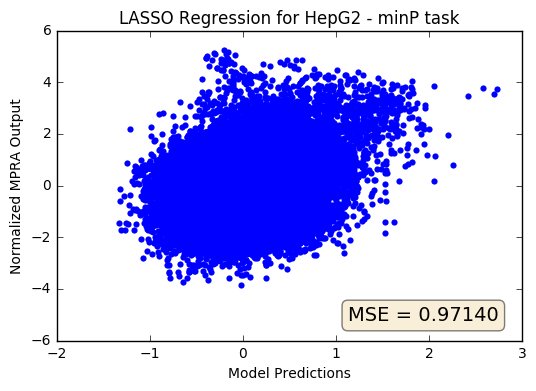

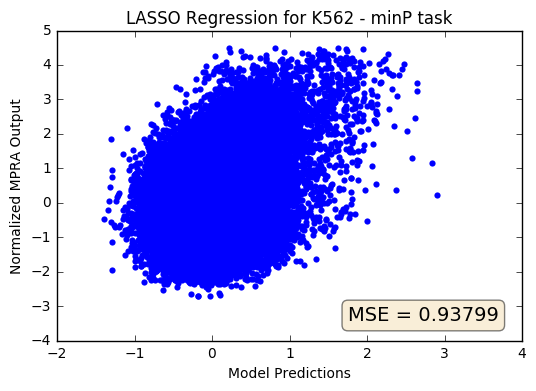

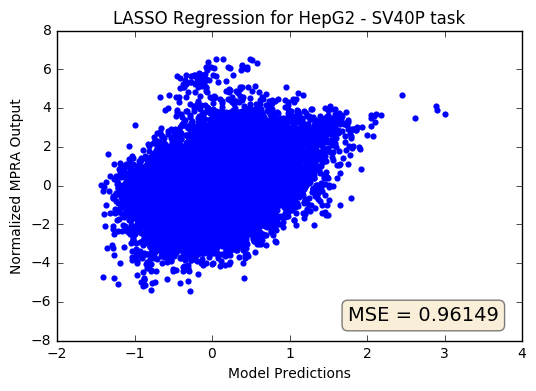

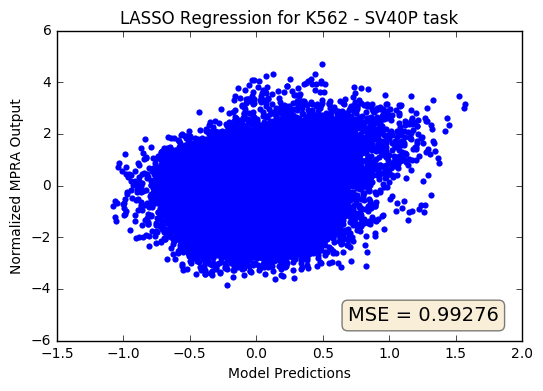

In [11]:
TASKS = ['HepG2 - minP', 'K562 - minP', 'HepG2 - SV40P', 'K562 - SV40P']
def plot_predictions(models, name):
    for task, model in enumerate(models):
        ax = plt.subplot(111)
        mse = sum([(i-j) **2 for i, j in zip(model.predict(Xk_test), y_test[:, task])]) / y_test[:, task].shape[0]
        plt.scatter(model.predict(Xk_test), y_test[:, task], lw = 0)
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.95, 0.05, "MSE = {}".format(str(mse)[:7]), transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
        
        plt.xlabel("Model Predictions")
        plt.ylabel("Normalized MPRA Output")
        plt.title("{} for {} task".format(name, TASKS[task]))
        plt.show()
plot_predictions(lasso_models, 'LASSO Regression')

In [9]:
import os.path

fn = "from_paper"
fn = model_dir + fn
model = SequenceDNN_Regression(
    seq_length=X_train.shape[3],
    num_filters=[100, 100],
    conv_width=[8, 15],
    pool_width=124,
    num_tasks=y_train.shape[1],
    dropout=0.1
)

In [10]:
model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Mean Squared Error: 0.9023	Mean Absolute Error: 0.7327	 Median Absolute Error: 0.5802	 R2 Score: 0.0844
Task 1: Mean Squared Error: 0.8762	Mean Absolute Error: 0.7496	 Median Absolute Error: 0.6440	 R2 Score: 0.1176
Task 2: Mean Squared Error: 0.8909	Mean Absolute Error: 0.6921	 Median Absolute Error: 0.5139	 R2 Score: 0.0984
Task 3: Mean Squared Error: 0.9543	Mean Absolute Error: 0.7838	 Median Absolute Error: 0.6676	 R2 Score: 0.0424
Valid Task 0: Mean Squared Error: 1.0025	Mean Absolute Error: 0.7661	 Median Absolute Error: 0.5973	 R2 Score: 0.0270
Task 1: Mean Squared Error: 0.9605	Mean Absolute Error: 0.7759	 Median Absolute Error: 0.6598	 R2 Score: 0.0516
Task 2: Mean Squared Error: 0.9897	Mean Absolute Error: 0.7210	 Median Absolute Error: 0.5294	 R2 Score: 0.0281
Task 3: Mean Squared Error: 0.9929	Mean Absolute Error: 0.7967	 Median Absolute Error: 0.6732	 R2 Score: 0.0055 *
Epoch 2:
Train Task 0: Mean Squar

In [12]:
model.plot_architecture(fn + '.png')
SequenceDNN_Regression.save(model, fn)

In [12]:
fn = "from_paper2"
fn = model_dir + fn
model = SequenceDNN_Regression(
    seq_length=X_train.shape[3],
    num_filters=[100, 100],
    conv_width=[8, 15],
    pool_width=124,
    num_tasks=y_train.shape[1],
    dropout=0.2
)

In [13]:
model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...


NameError: global name 'RegressionResult' is not defined

In [ ]:
model.plot_architecture(fn + '.png')
model.save(fn)

In [13]:
import matplotlib.gridspec as gridspec

def print_perf(model, metric):
    train_losses, valid_losses = [np.array([epoch_metrics[metric] for epoch_metrics in metrics])
                                  for metrics in (model.train_metrics, model.valid_metrics)]

    # Pretty sure early stopping works by taking the mean of losses, might want to double check
    mean_train_losses = train_losses.mean(axis=1)
    mean_valid_losses = valid_losses.mean(axis=1)
    min_loss_indx = min(enumerate(mean_valid_losses), key=lambda x: x[1])[0]
    
    gs = gridspec.GridSpec(3, 2)
    f = plt.figure(figsize=(15,10))

    for i in range(train_losses.shape[1]):
        y_max = max(max(train_losses[:,i]), max(valid_losses[:,i])) * 1.1

        ax = f.add_subplot(gs[i])

        ax.plot(range(len(train_losses[:,i])), train_losses[:,i], label='Training',lw=2)
        ax.plot(range(len(train_losses[:,i])), valid_losses[:,i], label='Validation', lw=2)
        
        ax.plot([min_loss_indx, min_loss_indx], [0, y_max], 'k--', label='Early Stop')
        if i == 0:
            ax.legend(loc="best")
            ax.set_ylabel(metric)
        ax.set_ylim((0,y_max))
        ax.set_title("Task {}".format(i))

    y_max = max(max(mean_train_losses), max(mean_valid_losses)) * 1.1

    ax = f.add_subplot(gs[train_losses.shape[1]])
    ax.plot(range(len(mean_train_losses)), mean_train_losses, label='Training',lw=2)
    ax.plot(range(len(mean_valid_losses)), mean_valid_losses, label='Validation', lw=2)
        
    ax.plot([min_loss_indx, min_loss_indx], [0, y_max], 'k--', label='Early Stop')
    ax.set_ylim((0,y_max))
    ax.set_xlabel("Epoch")
    ax.set_title("Mean losses")
        
    plt.savefig(fn + ".losses.png")
    plt.show()

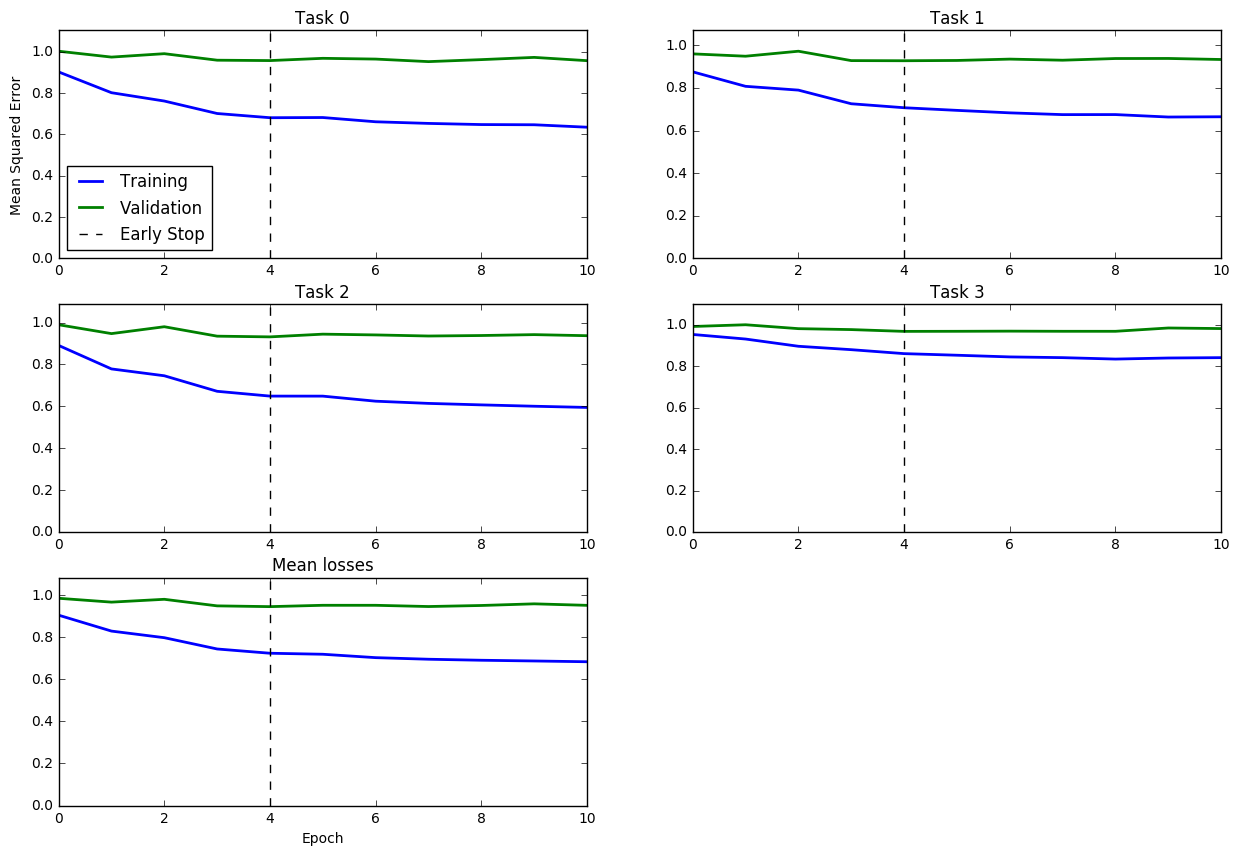

In [14]:
metric = "Mean Squared Error"
print_perf(model, metric)

In [22]:
num_filters = [60, 80, 100, 120]
dropouts = [0.05, 0.1, 0.15, 0.2, 0.25]
convs = [8, 10, 12, 14]
for num_filter in num_filters:
    for i, dropout in enumerate(dropouts):
        for conv in convs:
            fn = "reg_sep_{}_{}_{}".format(num_filter, i, conv)
            print fn
            print num_filter, dropout, conv, 145 - 2*conv + 2
            fn = model_dir + fn
            model = SequenceDNN_Regression(
                seq_length=X_train.shape[3],
                num_filters=[num_filter, num_filter],
                conv_width=[conv, conv],
                pool_width=145 - 2*conv + 2,
                num_tasks=y_train.shape[1],
                dropout=dropout
            )
            model.train(X_train, y_train, (X_valid, y_valid))
            metric = "Mean Squared Error"
            print_perf(model, metric)
            model.plot_architecture(fn + '.png')
            SequenceDNN_Regression.save(model, fn)

reg_sep_60_0_8
60 0.05 8 131


KeyboardInterrupt: 

reg_sep_100_0_8
100 0.05 8 131
Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Mean Squared Error: 0.8909	Mean Absolute Error: 0.7336	 Median Absolute Error: 0.5943	 R2 Score: 0.0960
Task 1: Mean Squared Error: 0.8908	Mean Absolute Error: 0.7546	 Median Absolute Error: 0.6448	 R2 Score: 0.1029
Task 2: Mean Squared Error: 0.8808	Mean Absolute Error: 0.6862	 Median Absolute Error: 0.5083	 R2 Score: 0.1086
Task 3: Mean Squared Error: 0.9661	Mean Absolute Error: 0.7933	 Median Absolute Error: 0.6842	 R2 Score: 0.0306
Valid Task 0: Mean Squared Error: 0.9834	Mean Absolute Error: 0.7643	 Median Absolute Error: 0.6137	 R2 Score: 0.0456
Task 1: Mean Squared Error: 0.9521	Mean Absolute Error: 0.7734	 Median Absolute Error: 0.6562	 R2 Score: 0.0598
Task 2: Mean Squared Error: 0.9705	Mean Absolute Error: 0.7148	 Median Absolute Error: 0.5261	 R2 Score: 0.0469
Task 3: Mean Squared Error: 0.9943	Mean Absolute Error: 0.8024	 Median Absolute Error: 0.6891	 R2 Score: 0.0041 *
Ep

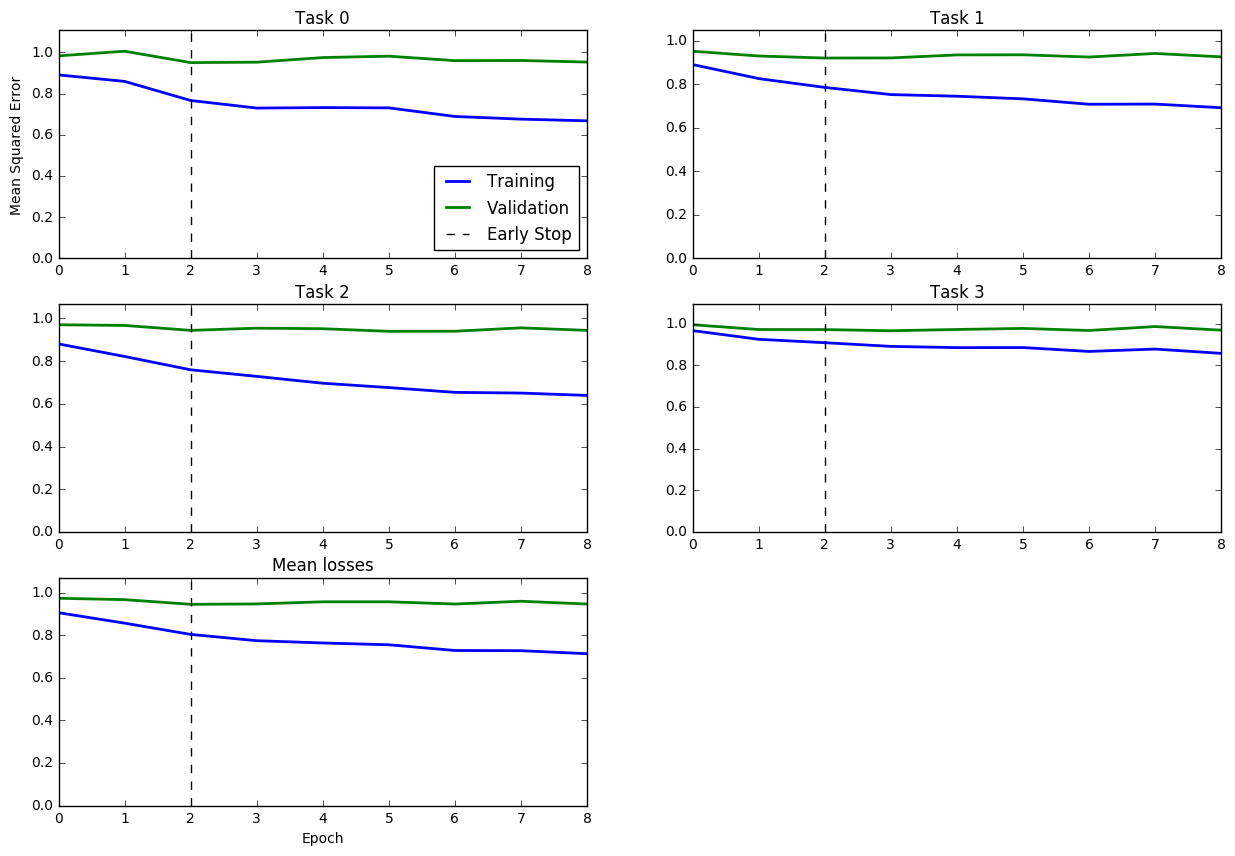

reg_sep_100_0_10
100 0.05 10 127
Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Mean Squared Error: 0.8598	Mean Absolute Error: 0.7208	 Median Absolute Error: 0.5813	 R2 Score: 0.1276
Task 1: Mean Squared Error: 0.8839	Mean Absolute Error: 0.7651	 Median Absolute Error: 0.6726	 R2 Score: 0.1098
Task 2: Mean Squared Error: 0.8711	Mean Absolute Error: 0.6794	 Median Absolute Error: 0.4943	 R2 Score: 0.1184
Task 3: Mean Squared Error: 0.9543	Mean Absolute Error: 0.7714	 Median Absolute Error: 0.6366	 R2 Score: 0.0425
Valid Task 0: Mean Squared Error: 0.9847	Mean Absolute Error: 0.7625	 Median Absolute Error: 0.6057	 R2 Score: 0.0443
Task 1: Mean Squared Error: 0.9728	Mean Absolute Error: 0.7959	 Median Absolute Error: 0.6933	 R2 Score: 0.0394
Task 2: Mean Squared Error: 0.9743	Mean Absolute Error: 0.7133	 Median Absolute Error: 0.5123	 R2 Score: 0.0432
Task 3: Mean Squared Error: 0.9872	Mean Absolute Error: 0.7839	 Median Absolute Error: 0.6425	 R2 Score: 0.0112 *


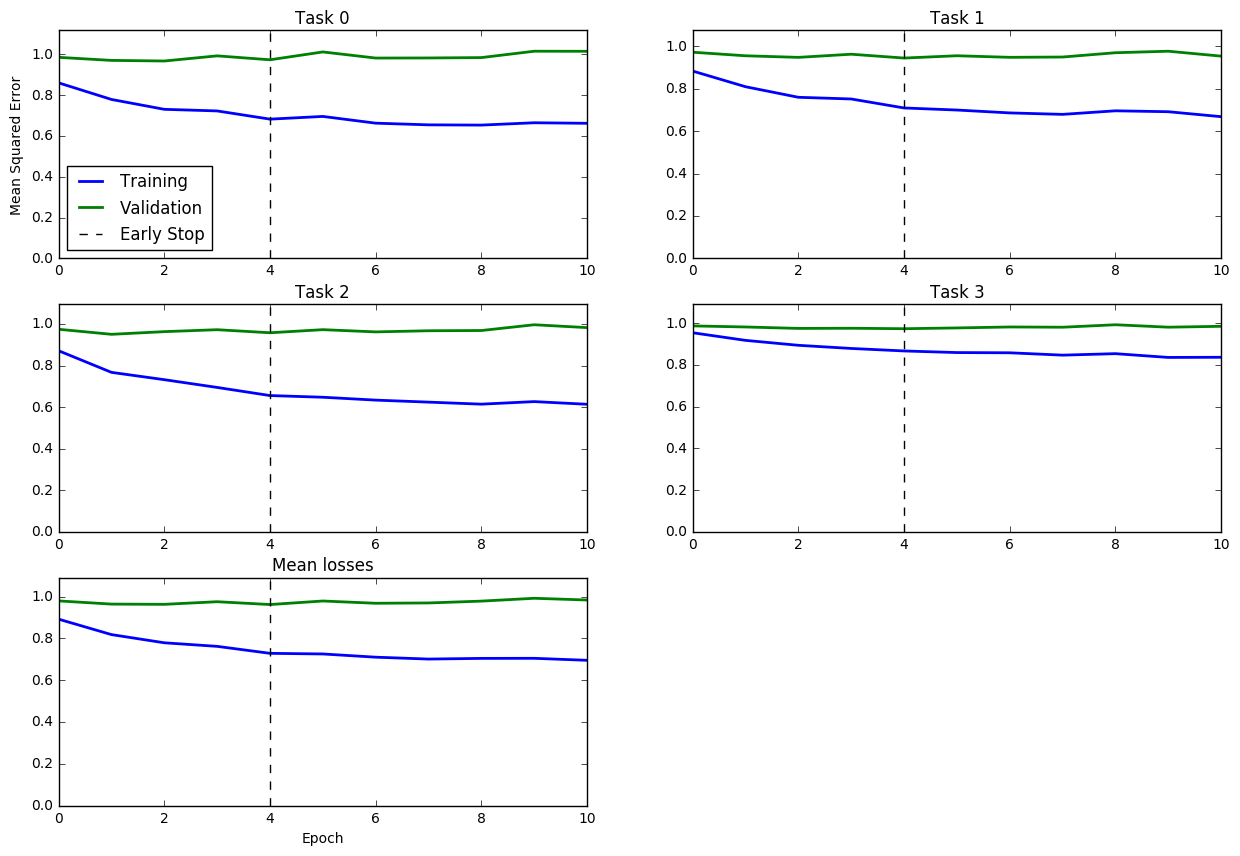

reg_sep_100_0_12
100 0.05 12 123
Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Mean Squared Error: 0.8914	Mean Absolute Error: 0.7459	 Median Absolute Error: 0.6257	 R2 Score: 0.0955
Task 1: Mean Squared Error: 0.8623	Mean Absolute Error: 0.7492	 Median Absolute Error: 0.6502	 R2 Score: 0.1315
Task 2: Mean Squared Error: 0.8771	Mean Absolute Error: 0.6967	 Median Absolute Error: 0.5322	 R2 Score: 0.1123
Task 3: Mean Squared Error: 0.9540	Mean Absolute Error: 0.7711	 Median Absolute Error: 0.6352	 R2 Score: 0.0428
Valid Task 0: Mean Squared Error: 1.0372	Mean Absolute Error: 0.7905	 Median Absolute Error: 0.6466	 R2 Score: -0.0066
Task 1: Mean Squared Error: 0.9645	Mean Absolute Error: 0.7831	 Median Absolute Error: 0.6721	 R2 Score: 0.0476
Task 2: Mean Squared Error: 1.0229	Mean Absolute Error: 0.7394	 Median Absolute Error: 0.5518	 R2 Score: -0.0046
Task 3: Mean Squared Error: 0.9901	Mean Absolute Error: 0.7836	 Median Absolute Error: 0.6417	 R2 Score: 0.0083 

KeyboardInterrupt: 

In [25]:
num_filters = [100]
dropouts = [0.05, 0.1, 0.15, 0.2, 0.25]
convs = [8, 10, 12, 14]
for num_filter in num_filters:
    for i, dropout in enumerate(dropouts):
        for conv in convs:
            fn = "reg_sep_{}_{}_{}".format(num_filter, i, conv)
            print fn
            print num_filter, dropout, conv, 145 - 2*conv + 2
            fn = model_dir + fn
            model = SequenceDNN_Regression(
                seq_length=X_train.shape[3],
                num_filters=[num_filter, num_filter],
                conv_width=[conv, conv],
                pool_width=145 - 2*conv + 2,
                num_tasks=y_train.shape[1],
                dropout=dropout
            )
            model.train(X_train, y_train, (X_valid, y_valid))
            metric = "Mean Squared Error"
            print_perf(model, metric)